In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with conda or pip  and then try again.")
    sys.exit()

from sklearn import ensemble
import kmapper as km
from kmapper.plotlyviz import *
from sklearn.decomposition import PCA
from kmapper import jupyter

import warnings
warnings.filterwarnings("ignore")

In this notebook we recreate some of the Mapper graphs presented in the paper https://arxiv.org/pdf/1904.11044.pdf

In [2]:
def objtxtToArray(fileName):
    #first open the file and sift through all the header lines
    file = open(fileName, "r")
    line = "not v"
    while(line[0] != "v"):
        line = file.readline()
    
    #The 3d coordinates have a header of 'v'. So, all the lines with v can then be taken and split in order to get coords
    x = []
    y = []
    z = []
    while(line[0] == "v"):
        temp = line.split()
        x.append(float(temp[1]))
        y.append(float(temp[2]))
        z.append(float(temp[3]))
        line = file.readline()
    
    #x, y, and z are easily collated to give 3d vectors to the points
    coords = np.stack([x, y, z], axis = 1)
    
    return coords

In [3]:
data = objtxtToArray("alienData(txt).txt")

In [4]:
data.shape

(14098, 3)

In the paper, all 3D objects were standardised to have height 1 in $\mathbb{R}^3$

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
#print(scaler.data_max_)
data = scaler.transform(data)

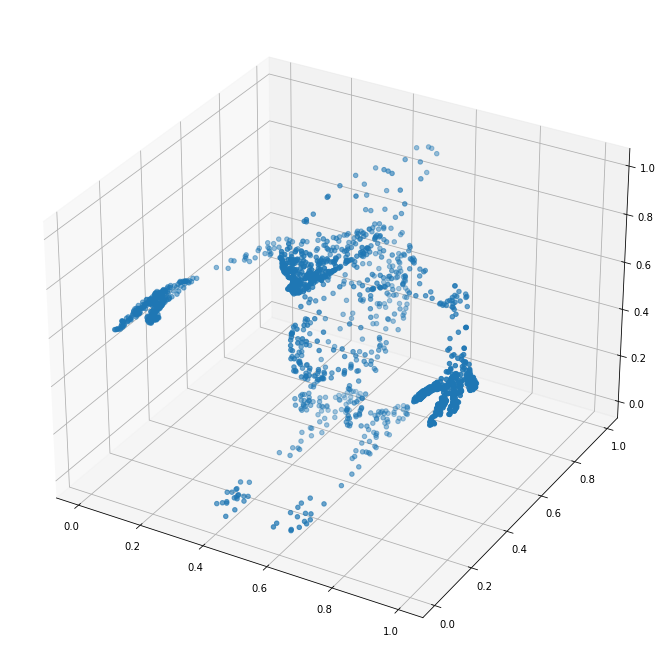

In [6]:
random_rows = np.random.choice(data.shape[0], 1500, replace = False)
sample = data[random_rows, :]
sample.shape

#plotting the data to get the alien
x = sample[:,0]
y = sample[:,1]
z = sample[:,2]

fig = plt.figure(figsize = (20,12))
#ax = plt.axes(projection="3d")
#ax.scatter(x, y, z, 'grey')


ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z)

plt.show()

In [7]:
import kmapper as km
from kmapper import jupyter
import networkx as nx

The paper uses the method of connected components of the $\epsilon$-neighbouring graph. I think this is DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

# Centrality function filter

There's a Scipy function called distance_matrix which returns the matrix of all pair-wise distances.

In [9]:
from scipy.spatial import distance_matrix

def centrality(data):
    distances = distance_matrix(data,data)
    sums = np.sum(distances, axis=0)
    centrality = sums/distances.shape[0]
    values = np.array([[i] for i in centrality])
    return values

In [10]:
cen = centrality(sample)

In [11]:
cen

array([[0.43928917],
       [0.59194497],
       [0.55829051],
       ...,
       [0.44134447],
       [0.47800749],
       [0.53201336]])

In [14]:
#initiate the mapper object
mapper = km.KeplerMapper(verbose = 0)

#this would filter using the z coordinate as before
#height = mapper.fit_transform(sample, projection = [2])

# Define the simplicial complex using different parameters. Note that lens=cen
graph = mapper.map(cen,
                   sample,
                   cover = km.Cover(n_cubes=5, perc_overlap=0.1),
                   clusterer = DBSCAN(eps =.1))

# Visualize it
html = mapper.visualize(graph, 
                        color_values= z,
                        color_function_name = 'height',
                        node_color_function = ['median', 'max', 'average'], 
                        path_html="alien.html",
                        title="Alien")

# Inline display
# jupyter.display(path_html="http://mlwave.github.io/tda/word2vec-gender-bias.html")
jupyter.display(path_html="alien.html")